In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2, pywrapcp

def create_data_model(waypoints):
    """Create the data model for the TSP."""
    return {
        'distance_matrix': compute_distance_matrix(waypoints),
        'num_vehicles': 1,
        'depot': 0
    }

def compute_distance_matrix(waypoints):
    """Compute the distance matrix for the given waypoints."""
    def distance(p1, p2):
        return int(np.linalg.norm(np.array(p1) - np.array(p2)))
    return [[distance(p1, p2) for p2 in waypoints] for p1 in waypoints]

def print_solution(manager, routing, solution):
    print('TSP Distance: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    return plan_output

def angle_between_points(p1, p2):
    """Calculate the angle between two points."""
    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

def point_on_circle(center, angle, radius):
    """Calculate the point on a circle given center, angle, and radius."""
    x = center[0] + radius * np.cos(angle)
    y = center[1] + radius * np.sin(angle)
    return (x, y)

def draw_circle(ax, center, radius):
    """Draw a circle on the given axes."""
    circle = plt.Circle(center, radius, color='b', fill=False)
    ax.add_artist(circle)

In [2]:
def plot_solution(waypoints, plan_output, radius):
    """Plot the TSP solution."""
    ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
    ordered_points.append(ordered_points[0])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(*zip(*ordered_points))

    for i, point in enumerate(ordered_points[:-1]):
        plt.annotate(i, (point[0] + 0.5, point[1] + 0.5))
        if i > 0 and i < len(ordered_points) - 2:  # Exclude start and end points from circles
            draw_circle(ax, point, radius)

    new_path = [ordered_points[0]]
    for i in range(1, len(ordered_points) - 2):
        # calculate angle and chords for the current waypoint
        angle = angle_between_points(ordered_points[i-1], ordered_points[i])
        nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
        chord_start = point_on_circle(ordered_points[i], angle - np.pi , radius)
        chord_end = point_on_circle(ordered_points[i], nextangle , radius)

        # calculate the chord for the previous waypoint
        prev_angle = angle_between_points(ordered_points[i - 2] if i > 1 else ordered_points[0], ordered_points[i-1])
        prev_chord_end = point_on_circle(ordered_points[i-1], prev_angle + np.pi / 2, radius)

        # add the point on the current waypoint's circle that is closest to the previous waypoint
        if np.linalg.norm(np.array(chord_start) - np.array(prev_chord_end)) < np.linalg.norm(np.array(chord_end) - np.array(prev_chord_end)):
            new_path.extend([chord_start, chord_end])
            ax.plot(*zip(*[chord_start, chord_end]), 'r-')  # visualize the chord
        else:
            new_path.extend([chord_end, chord_start])
            ax.plot(*zip(*[chord_end, chord_start]), 'r-')  # visualize the chord

    # add the ending point
    new_path.append(ordered_points[-1])
    total_distance = sum(np.linalg.norm(np.array(new_path[i]) - np.array(new_path[i+1])) for i in range(len(new_path) - 1))
    print(f"Total distance of new path: {total_distance:.2f}")
    ax.plot(*zip(*new_path), linestyle='-', marker='o')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Solution')
    plt.grid()
    plt.axis('equal')
    plt.show()
    return total_distance

In [12]:
def distance_callback(from_index, to_index, manager, distance_matrix):
    """Callback function to get the distance between two points."""
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return distance_matrix[from_node][to_node]

def main(waypoints, radius=5):
    """Solve the TSP for the given waypoints."""
    data = create_data_model(waypoints)
    
    # Create routing manager and model
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    
    # Register the distance callback
    transit_callback_index = routing.RegisterTransitCallback(
        lambda from_index, to_index: distance_callback(from_index, to_index, manager, data['distance_matrix']))
    
    # Set arc cost evaluator for all vehicles
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Set search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    # Solve the TSP
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        plan_output = print_solution(manager, routing, solution)
        plot_solution_fixed(waypoints, plan_output, radius)
        return plan_output
    return None


In [9]:
def plot_solution_fixed(waypoints, plan_output, radius):
    """Plot the TSP solution with the chord connection bug fixed."""
    ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
    ordered_points.append(ordered_points[0])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(*zip(*ordered_points))

    for i, point in enumerate(ordered_points[:-1]):
        plt.annotate(i, (point[0] + 0.5, point[1] + 0.5))
        if i > 0 and i < len(ordered_points) - 2:  # Exclude start and end points from circles
            draw_circle(ax, point, radius)

    new_path = [ordered_points[0]]
    for i in range(1, len(ordered_points) - 2):
        # calculate angle and chords for the current waypoint
        angle = angle_between_points(ordered_points[i-1], ordered_points[i])
        nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
        chord_start = point_on_circle(ordered_points[i], angle - np.pi , radius)
        chord_end = point_on_circle(ordered_points[i], nextangle , radius)

        # If the chord_start is closer to the previous waypoint, it should be the incoming path.
        # Otherwise, chord_end should be the incoming path.
        if np.linalg.norm(np.array(chord_start) - np.array(ordered_points[i-1])) < np.linalg.norm(np.array(chord_end) - np.array(ordered_points[i-1])):
            new_path.extend([chord_start, ordered_points[i], chord_end])
            ax.plot(*zip(*[chord_start, ordered_points[i], chord_end]), 'r-')  # visualize the chord
        else:
            new_path.extend([chord_end, ordered_points[i], chord_start])
            ax.plot(*zip(*[chord_end, ordered_points[i], chord_start]), 'r-')  # visualize the chord

    # add the ending point
    new_path.append(ordered_points[-1])
    total_distance = sum(np.linalg.norm(np.array(new_path[i]) - np.array(new_path[i+1])) for i in range(len(new_path) - 1))
    print(f"Total distance of new path: {total_distance:.2f}")
    ax.plot(*zip(*new_path), linestyle='-', marker='o')
    

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Solution')
    plt.grid()
    plt.axis('equal')
    plt.show()
    return total_distance

TSP Distance: 99 miles
Route for vehicle 0:
 0 -> 5 -> 1 -> 2 -> 3 -> 4 -> 0

Total distance of new path: 101.00


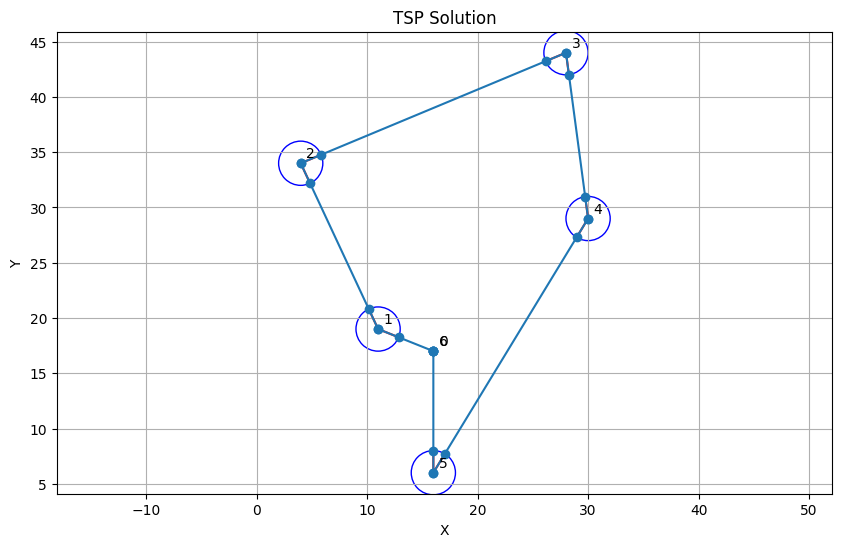

In [16]:
if __name__ == '__main__':
    waypoints = [(random.randint(0, 50), random.randint(0, 50)) for _ in range(6)]
    # waypoints = [(0, 47), (1, 2), (5, 20), (32, 43)]
    radius = 2
    plan_output = main(waypoints, radius)

In [17]:
waypoints

[(16, 17), (4, 34), (28, 44), (30, 29), (16, 6), (11, 19)]

Total distance of new path: 129.55


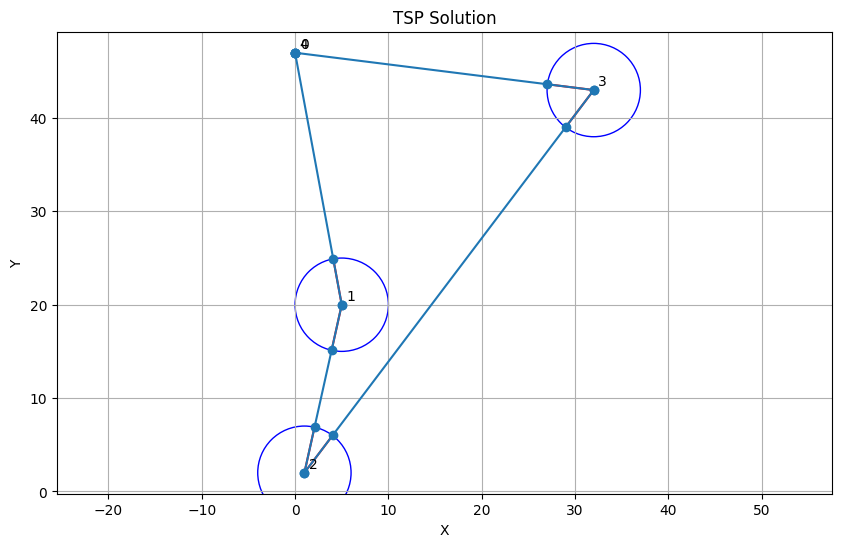

129.54756944685752

In [23]:
waypoints_test = [(0, 47), (1, 2), (5, 20), (32, 43)]

tsp_output = '0 -> 2 -> 1 -> 3 -> 0'

radius = 5

plot_solution_fixed(waypoints_test, tsp_output, radius)

In [13]:
bugged_waypponts = waypoints
bugged_waypponts

[(0, 47), (1, 2), (5, 20), (32, 43)]